In [3]:
# Preamble
import sys
import os
import numpy as np

# Within my docker image thats the path 
sys.path.append('/Code/Reimplementations/')


## Likelihood Function Comparisons

Here we compare the individual methods and assure that these produce the same outputs

In order:
- Tensorflow vs Jax
- Jax vs Numpy
- Numpy vs Numba

The likelihood ratios show significant deviation (on a float precision level) but this is expected due to compounding errors

TODO Need to implement MLE for exact for all three

In [9]:
# Dont need to use as many parameters as usually
# And all but n_pmts are the default set of parameters used
n_pmts = 100
return_ratio = False 
switching_signal=40 
n_sigma=5
sigma_min=0.05 
sigma_max=1 
z=20
p_dpe=0.2
nan_safe=True 
nan_safe_value = 1e5 
m=5
mle_estimator = None

# JAX implementation requirements (hardcoded in tf )
obs_min = -3 

# Range of Stds for evaluation 
stds = np.linspace(0.05, 0.95, n_pmts)
stds = np.full((n_pmts,), 0.5)  # Use a constant value for all PMTs

In [5]:
%load_ext autoreload
# Reload all modules before running a cell
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Tensorflow vs Jax

In [3]:
# Compare Exact methods and LUT tables (both compute via exact and produce LUT)

from TensorflowImplementation.LikelihoodFunction import LikelihoodRatio
from JAXReimplementation import LikelihoodFunction as LikelihoodFunctionJAX


tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = return_ratio, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = nan_safe, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
# Precompute LUT table
tf_implement.std.assign(stds)
tf_implement.set_call_mode("LUT_untrainable_std", return_ratio = True)

tf_LUT = tf_implement.L_table
tf_LUT_mle = tf_implement.L_mle_table
tf_x_domain = tf_implement.x_domain
tf_mu_domain = tf_implement.mu_domain

jax_LUT, jax_LUT_MLE, jax_x_domain, jax_mu_domain = LikelihoodFunctionJAX.generate_LUT(
    m = m,
    p = p_dpe,
    switching_signal = switching_signal,
    gaussian_stds = stds,
    n_sigma = n_sigma, 
    obs_min = obs_min
)

"""
Notes on closeness of values

Gaussian component is equivalent using np.isclose 
Binomial is close using rtol = 1.16e-5 and atol = 0 (around 2% of data tested)
Poisson is close using rtol = 5e-5 and atol = 0 

Exact Likelihood aligns with rtol = 3e-5 and atol = 0 

LUT with rtol 3e-5 and atol = 0

"""

2025-06-04 10:38:38.305635: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 10:38:38.369930: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-04 10:38:38.370098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-04 10:38:38.372413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 10:38:38.384248: I tensorflow/core/platform/cpu_feature_guar

'\nNotes on closeness of values\n\nGaussian component is equivalent using np.isclose \nBinomial is close using rtol = 1.16e-5 and atol = 0 (around 2% of data tested)\nPoisson is close using rtol = 5e-5 and atol = 0 \n\nExact Likelihood aligns with rtol = 3e-5 and atol = 0 \n\nLUT with rtol 3e-5 and atol = 0\n\n'

In [4]:
# Validate the two methods produce the same numerical results
assert np.allclose(tf_x_domain, jax_x_domain), "x domains do not match!"
assert np.allclose(tf_mu_domain, jax_mu_domain), "mu domains do not match!"
assert np.allclose(jax_LUT, tf_LUT, rtol = 3e-5, atol=0), "LUTs do not match!"
assert np.allclose(tf_LUT_mle, jax_LUT_MLE, rtol = 2e-5, atol=0), "MLE LUTs do not match!"

In [27]:
# Now full chain with parent call exact
tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = return_ratio, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = nan_safe, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
tf_implement.std.assign(stds)
tf_implement.set_call_mode("exact", return_ratio = False)
tf_implement.std.assign(stds)

jax_implement = LikelihoodFunctionJAX.parent_gen(stds,
                                                 method = 'Exact',
                                                 return_ratio=False,
                                                 switching_signal = switching_signal,
                                                 p_dpe = p_dpe,
                                                 n_sigma = n_sigma,
                                                 m = m,
                                                 )

# Generate some random data to test
n_samples = 1000
x= np.random.uniform(-3,40, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)
print("Exact only branch")
print(np.allclose(res1, res2))

n_samples = 1000
x= np.random.uniform(40,1000, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Gaussian only branch")
print(np.allclose(res1, res2))

n_samples = 1000
x= np.random.uniform(-3,100, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Mixed branch")
print(np.allclose(res1, res2))

Exact only branch
True
Gaussian only branch
True
Mixed branch
True


In [29]:
from TensorflowImplementation.LikelihoodFunction import LikelihoodRatio
from JAXReimplementation import LikelihoodFunction as LikelihoodFunctionJAX

# Now full chain with parent call on LUT
tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = True, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = False, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
tf_implement.std.assign(stds)
tf_implement.set_call_mode("LUT_untrainable_std", return_ratio = True)

jax_implement = LikelihoodFunctionJAX.parent_gen(stds,
                                                 method = 'LUT',
                                                 return_ratio=True,
                                                 switching_signal = switching_signal,
                                                 p_dpe = p_dpe,
                                                 n_sigma = n_sigma,
                                                 m = m,
                                                 )

# Generate some random data to test
n_samples = 1000
x= np.random.uniform(-3,40, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)
print("Exact only branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=0))
print(np.isclose(res1, res2, rtol = 3e-5, atol=0).mean())

n_samples = 1000
x= np.random.uniform(40,1000, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Gaussian only branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=0))
print(np.isclose(res1, res2, rtol = 3e-5, atol=0).mean())

n_samples = 1000
x= np.random.uniform(-3,100, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Mixed branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=0))
print(np.isclose(res1, res2, rtol = 3e-5, atol=0).mean())


Exact only branch
False
0.9858
Gaussian only branch
False
0.39616
Mixed branch
False
0.64576


Guassian Likelihood
True
Guassian MLE Likelihood
True
Loss function Gaussian
False
0.49015
max relative diff: 0.2413793
Sanity Check
NLLR Gaussian
False
0.49015
max relative diff: 0.2413793


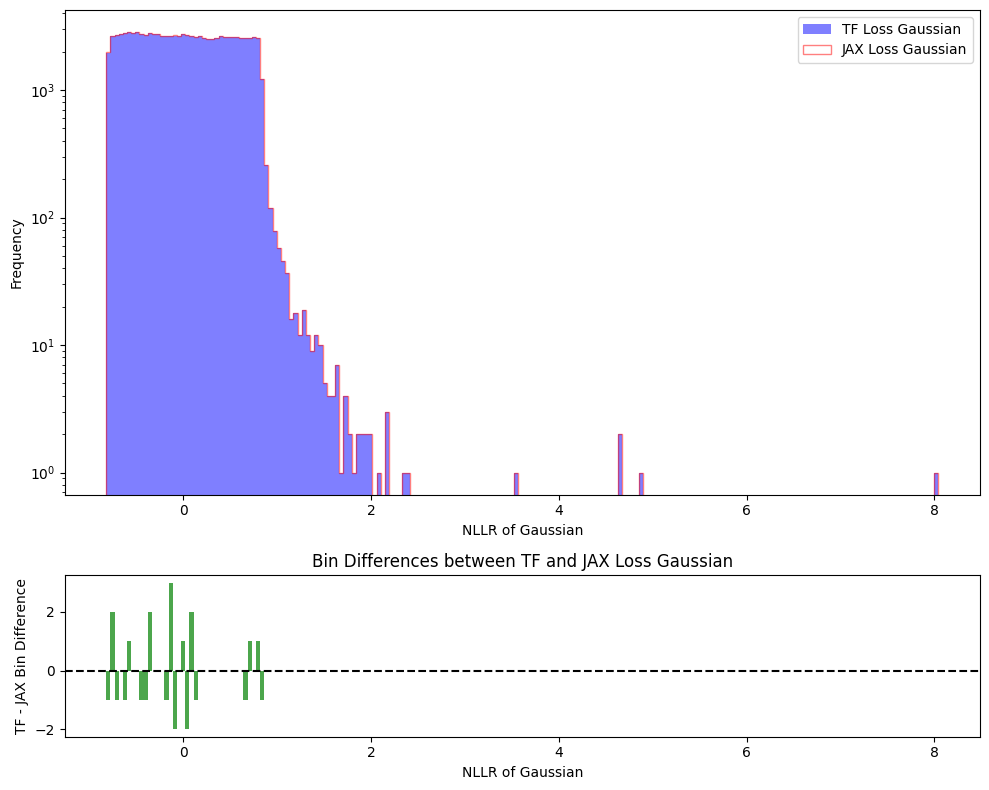

In [56]:
"""
A note on the Likelihood Ratio

It seems that the float computation error compounds strongly when computing the ratio, 
this is simply a result of small values and the way relative error scales

Below is the example for the Guassian Component only

Since the MLE tables are close, and the log Likelihoods are close no further evaluation is required 
and this is simply an inherent numerical problem

"""
likelihoodFunctionGauss = LikelihoodFunctionJAX.gaussian_approx(
                                            p_dpe = p_dpe,
                                            )

likelihoodMLEFunctionGauss = LikelihoodFunctionJAX.gaussian_approx_MLE(
                                    p_dpe = p_dpe,
                                    )

lossfunc_Gauss = LikelihoodFunctionJAX.lossFuncGenerator(
    likelihoodFunction=likelihoodFunctionGauss,
    ratio=True,
    likelihoodMLEFunction=likelihoodMLEFunctionGauss,
    log = True,
)

ltfgauss = tf_implement.gaussian_likelihood
ltfmlegauss = lambda x,  std: ltfgauss(x, x, std) #As implemented in tf llr func
lossfunctfGauss = tf_implement.gaussian_log_likelihood_ratio

x= np.random.uniform(3,1000, size=n_samples * n_pmts).astype('float32')
mu = x + np.random.uniform(-3,3, size=n_samples * n_pmts).astype('float32')
stds = np.random.uniform(0.05, 0.95, size=n_samples * n_pmts).astype('float32')

# Compare each corresponding component
tf_gauss = ltfgauss(x, mu, stds)
jax_gauss = likelihoodFunctionGauss(x, mu, stds)
print("Guassian Likelihood")
print(np.allclose(tf_gauss, jax_gauss))

tf_gauss_mle = ltfmlegauss(x, stds)
jax_gauss_mle = likelihoodMLEFunctionGauss(x, stds)
print("Guassian MLE Likelihood")
print(np.allclose(tf_gauss_mle, jax_gauss_mle))

# Compare the loss functions
tf_loss_gauss = lossfunctfGauss(x, mu, stds)
jax_loss_gauss = lossfunc_Gauss(x, mu, stds)
print("Loss function Gaussian")
print(np.allclose(tf_loss_gauss, jax_loss_gauss))
print(np.isclose(tf_loss_gauss, jax_loss_gauss).mean())
print('max relative diff:', (np.abs(tf_loss_gauss - jax_loss_gauss)/np.maximum(np.abs(tf_loss_gauss), 1e-10)).max())

print("Sanity Check")
def do_NLLR(log_like, mle):
    def NLLR(x, mu,std):
        return -2*(log_like(x,mu,std) - mle(x,std))
    return NLLR
tf_nllr_gauss = do_NLLR(ltfgauss, ltfmlegauss)(x, mu,stds)
jax_nllr_gauss = do_NLLR(likelihoodFunctionGauss, likelihoodMLEFunctionGauss)(x, mu,stds)
print("NLLR Gaussian")
print(np.allclose(tf_nllr_gauss, jax_nllr_gauss))
print(np.isclose(tf_nllr_gauss, jax_nllr_gauss).mean())
print('max relative diff:', (np.abs(tf_nllr_gauss - jax_nllr_gauss)/np.maximum(np.abs(tf_nllr_gauss), 1e-10)).max())

import matplotlib.pyplot as plt

# Histogram parameters
bins = 200

# Compute histograms
hist_tf, bin_edges = np.histogram(tf_loss_gauss, bins=bins)
hist_jax, _ = np.histogram(jax_loss_gauss, bins=bin_edges)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_differences = hist_tf - hist_jax


# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})


# First subplot: original histograms
ax1.hist(tf_loss_gauss, bins=bins, alpha=0.5, label='TF Loss Gaussian', color='blue')
ax1.hist(jax_loss_gauss, bins=bins, alpha=0.5, label='JAX Loss Gaussian', color='red', histtype='step')
ax1.set_yscale('log')
ax1.set_xlabel('NLLR of Gaussian')
ax1.set_ylabel('Frequency')
ax1.legend()

# Second subplot: differences
ax2.bar(bin_centers, bin_differences, width=np.diff(bin_edges), color='green', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel('NLLR of Gaussian')
ax2.set_ylabel('TF - JAX Bin Difference')
ax2.set_title('Bin Differences between TF and JAX Loss Gaussian')

plt.tight_layout()
plt.show()

### Tensorflow vs Numpy/Numba

In [6]:
# Compare LUTS for Numpy

from TensorflowImplementation.LikelihoodFunction import LikelihoodRatio
from Numpy_NumbaReimplementation import np_LikelihoodFunction as LikelihoodFunction


tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = return_ratio, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = nan_safe, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
# Precompute LUT table
tf_implement.std.assign(stds)
tf_implement.set_call_mode("LUT_untrainable_std", return_ratio = True)

tf_LUT = tf_implement.L_table
tf_LUT_mle = tf_implement.L_mle_table
tf_x_domain = tf_implement.x_domain
tf_mu_domain = tf_implement.mu_domain

jax_LUT, jax_LUT_MLE, jax_x_domain, jax_mu_domain = LikelihoodFunction.generate_LUT(
    m = m,
    p = p_dpe,
    switching_signal = switching_signal,
    gaussian_stds = stds,
    n_sigma = n_sigma, 
    obs_min = obs_min,
)

"""
Notes on closeness of values

Gaussian component is equivalent using np.isclose 
Binomial is close using rtol = 1.16e-5 and atol = 0 (around 2% of data tested)
Poisson is close using rtol = 5e-5 and atol = 0 

Exact Likelihood aligns with rtol = 3e-5 and atol = 0 

LUT with rtol 3e-5 and atol = 0

"""

'\nNotes on closeness of values\n\nGaussian component is equivalent using np.isclose \nBinomial is close using rtol = 1.16e-5 and atol = 0 (around 2% of data tested)\nPoisson is close using rtol = 5e-5 and atol = 0 \n\nExact Likelihood aligns with rtol = 3e-5 and atol = 0 \n\nLUT with rtol 3e-5 and atol = 0\n\n'

In [7]:
# Validate the two methods produce the same numerical results
assert np.allclose(tf_x_domain, jax_x_domain), "x domains do not match!"
assert np.allclose(tf_mu_domain, jax_mu_domain), "mu domains do not match!"
# Needed a tiny atol because of null entries not being exactly null 
assert np.allclose(jax_LUT, tf_LUT, rtol = 3e-5, atol=1e-30), "LUTs do not match!"
assert np.allclose(tf_LUT_mle, jax_LUT_MLE, rtol = 2e-5, atol=0), "MLE LUTs do not match!"

In [105]:
# Compare LUTS for Numba

from TensorflowImplementation.LikelihoodFunction import LikelihoodRatio
from Numpy_NumbaReimplementation import nb_LikelihoodFunction as LikelihoodFunction


jax_LUT, jax_LUT_MLE, jax_x_domain, jax_mu_domain = LikelihoodFunction.generate_LUT(
    m = m,
    p = p_dpe,
    switching_signal = switching_signal,
    gaussian_stds = stds,
    n_sigma = n_sigma, 
    obs_min = obs_min,
    float_type=np.float32,  # Ensure float32 for consistency with TensorFlow
)

import tensorflow as tf
tf.keras.mixed_precision.set_global_policy("float32")
tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = return_ratio, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = nan_safe, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
# Precompute LUT table
tf_implement.std.assign(stds)
tf_implement.set_call_mode("LUT_untrainable_std", return_ratio = True)

tf_LUT = tf_implement.L_table
tf_LUT_mle = tf_implement.L_mle_table
tf_x_domain = tf_implement.x_domain
tf_mu_domain = tf_implement.mu_domain

"""
Notes on closeness of values

Gaussian component is equivalent using np.isclose 
Binomial is close using rtol = 1.16e-5 and atol = 0 (around 2% of data tested)
Poisson is close using rtol = 5e-5 and atol = 0 

Exact Likelihood aligns with rtol = 3e-5 and atol = 0 

LUT with rtol 3e-5 and atol = 0

"""

'\nNotes on closeness of values\n\nGaussian component is equivalent using np.isclose \nBinomial is close using rtol = 1.16e-5 and atol = 0 (around 2% of data tested)\nPoisson is close using rtol = 5e-5 and atol = 0 \n\nExact Likelihood aligns with rtol = 3e-5 and atol = 0 \n\nLUT with rtol 3e-5 and atol = 0\n\n'

In [107]:
# Validate the two methods produce the same numerical results
assert np.allclose(tf_x_domain, jax_x_domain), "x domains do not match!"
assert np.allclose(tf_mu_domain, jax_mu_domain), "mu domains do not match!"
# Needed a tiny atol because of null entries not being exactly null 
assert np.allclose(jax_LUT, tf_LUT, rtol = 3e-5, atol=1e-30), "LUTs do not match!"
assert np.allclose(tf_LUT_mle, jax_LUT_MLE, rtol = 2e-5, atol=0), "MLE LUTs do not match!"

In [171]:
# parent exact  nb
from TensorflowImplementation.LikelihoodFunction import LikelihoodRatio
from Numpy_NumbaReimplementation import LikelihoodFunction as LikelihoodFunction
# Now full chain with parent call exact
tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = return_ratio, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = nan_safe, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
tf_implement.std.assign(stds)
tf_implement.set_call_mode("exact", return_ratio = False)
tf_implement.std.assign(stds)


jax_implement = LikelihoodFunction.parent_gen(stds,
                                                 method = 'Exact',
                                                 return_ratio=False,
                                                 switching_signal = switching_signal,
                                                 p_dpe = p_dpe,
                                                 n_sigma = n_sigma,
                                                 m = m,
                                                 usenumba=True,
                                                 )

# Generate some random data to test
n_samples = 1000
x= np.random.uniform(-3,40, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)
print("Exact only branch")
print(np.allclose(res1, res2))

n_samples = 1000
x= np.random.uniform(40,1000, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Gaussian only branch")
print(np.allclose(res1, res2))

n_samples = 1000
x= np.random.uniform(-3,100, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Mixed branch")
print(np.allclose(res1, res2))

Exact only branch
True
Gaussian only branch
True
Mixed branch
True


In [183]:
# parent : LUT ratio nb
from TensorflowImplementation.LikelihoodFunction import LikelihoodRatio
from Numpy_NumbaReimplementation import LikelihoodFunction as LikelihoodFunction

tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = True, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = False, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
tf_implement.std.assign(stds)
tf_implement.set_call_mode("LUT_untrainable_std", return_ratio = True)

jax_implement = LikelihoodFunction.parent_gen(stds,
                                                 method = 'LUT',
                                                 return_ratio=True,
                                                 switching_signal = switching_signal,
                                                 p_dpe = p_dpe,
                                                 n_sigma = n_sigma,
                                                 m = m,
                                                 usenumba=True,
                                                 )

# Generate some random data to test
n_samples = 1000
x= np.random.uniform(-3,40, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)
print("Exact only branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=1e-10))
print(np.isclose(res1, res2, rtol = 3e-5, atol=1e-10).mean())

n_samples = 1000
x= np.random.uniform(40,1000, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Gaussian only branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=1e-10))
print(np.isclose(res1, res2, rtol = 3e-5, atol=1e-10).mean())

n_samples = 1000
x= np.random.uniform(-3,100, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Mixed branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=0))
print(np.isclose(res1, res2, rtol = 3e-5, atol=0).mean())


Exact only branch
False
0.9861
Gaussian only branch
False
0.35216
Mixed branch
False
0.60479


In [167]:
# parent exact np
tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = return_ratio, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = nan_safe, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
tf_implement.std.assign(stds)
tf_implement.set_call_mode("exact", return_ratio = False)
tf_implement.std.assign(stds)

jax_implement = LikelihoodFunction.parent_gen(stds,
                                                 method = 'Exact',
                                                 return_ratio=False,
                                                 switching_signal = switching_signal,
                                                 p_dpe = p_dpe,
                                                 n_sigma = n_sigma,
                                                 m = m,
                                                 usenumba=False,
                                                 )

# Generate some random data to test
n_samples = 1000
x= np.random.uniform(-3,40, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)
print("Exact only branch")
print(np.allclose(res1, res2))

n_samples = 1000
x= np.random.uniform(40,1000, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Gaussian only branch")
print(np.allclose(res1, res2))

n_samples = 1000
x= np.random.uniform(-3,100, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Mixed branch")
print(np.allclose(res1, res2))

Exact only branch
True
Gaussian only branch
True
Mixed branch
True


In [184]:
# parent LUT ratio np 
tf_implement = LikelihoodRatio( n_pmts, 
                                return_ratio = True, 
                                switching_signal = switching_signal, 
                                n_sigma = n_sigma,
                                sigma_min = sigma_min, 
                                sigma_max = sigma_max, 
                                z = z,
                                p_dpe = p_dpe, 
                                nan_safe = False, 
                                nan_safe_value = nan_safe_value, 
                                m = m,  
                                mle_estimator = mle_estimator, 
                              )
tf_implement.std.assign(stds)
tf_implement.set_call_mode("LUT_untrainable_std", return_ratio = True)

jax_implement = LikelihoodFunction.parent_gen(stds,
                                                 method = 'LUT',
                                                 return_ratio=True,
                                                 switching_signal = switching_signal,
                                                 p_dpe = p_dpe,
                                                 n_sigma = n_sigma,
                                                 m = m,
                                                 usenumba=False,
                                                 )

# Generate some random data to test
n_samples = 1000
x= np.random.uniform(-3,40, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)
print("Exact only branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=0))
print(np.isclose(res1, res2, rtol = 3e-5, atol=0).mean())

n_samples = 1000
x= np.random.uniform(40,1000, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = x / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Gaussian only branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=0))
print(np.isclose(res1, res2, rtol = 3e-5, atol=0).mean())

n_samples = 1000
x= np.random.uniform(-3,100, size=n_samples * n_pmts).reshape(n_samples, n_pmts).astype('float32')
mu = np.clip(x, 0, None) / np.sum(np.where(x >= 0, x, 0), axis=1, keepdims=True)  # Normalize mu to sum to 1

res1 = tf_implement(mu, x)
res2 = jax_implement(x = x, mu = mu)

print("Mixed branch")
print(np.allclose(res1, res2, rtol = 3e-5, atol=0))
print(np.isclose(res1, res2, rtol = 3e-5, atol=0).mean())


Exact only branch
False
0.98126
Gaussian only branch
False
0.51932
Mixed branch
False
0.69698


### Timing 

## Neural Methods 

Only need to implement the final shared model whatever it is going to be

## Cython Likelihood Function

Fully implemented but not further used, noticed it was going to be much more of a pain to do so

In [4]:
%load_ext Cython

In [10]:
%%cython
# cython: boundscheck=False, wraparound=False
# distutils: extra_compile_args = -fopenmp
# distutils: extra_link_args    = -fopenmp

from libc.stdlib   cimport malloc, free
from libc.math     cimport sqrt, log, M_PI, lgamma, lgammaf, exp, floor, floorf, INFINITY, fabs, fabsf
from cython.parallel import prange
cimport cython

import numpy as np
cimport numpy as np

ctypedef fused DType:
    float
    double

ctypedef fused NPDType:
    np.float32_t
    np.float64_t

###           Make ph_pe_dpmain
cdef inline DType[::1] _make_domain(DType maximum):
    cdef int length = <int>(maximum) + 1
    cdef DType *buf = <DType *> malloc(length * sizeof(DType))
    if not buf:
        raise MemoryError()
    cdef int i
    with nogil:
        for i in range(length):
            buf[i] = i
    # cast to a length-checked 1D memoryview;
    # Cython will free buf when this view is GC’d
    return <DType[:length]>buf

# 3) C-only helper, returns two memoryviews
cdef tuple gen_pe_ph_domain(DType switching_signal,
                             int   n_sigma,
                             DType p_dpe):
    cdef DType pe_max = switching_signal \
                       + n_sigma * sqrt(switching_signal) + 2
    cdef DType ph_max = switching_signal/(1 + p_dpe) \
                       + n_sigma * sqrt(switching_signal/(1 + p_dpe)) + 2

    cdef DType[::1] pe = _make_domain(pe_max)
    cdef DType[::1] ph = _make_domain(ph_max)
    return pe, ph

# Likelihood functions

cdef double _LOG2PI = 0.9189385332046727#0.5 * log(2.0 * M_PI)

cdef inline DType gaussian_log_likelihood(DType x, DType mu, DType std) noexcept nogil:
    return -( 0.5*((x - mu)/std)**2  + <DType>_LOG2PI + log(std) )

# Use either float or double depending on input
cdef inline DType mylgamma(DType x) noexcept nogil:
    # sizeof(DType)==sizeof(float) is a compile‐time constant
    if sizeof(DType) == sizeof(float):
        # call the float version
        return <DType>lgammaf(<float>x)
    else:
        # call the double version
        return <DType>lgamma(<double>x)

cdef inline DType myabs(DType x) noexcept nogil:
    # sizeof(DType)==sizeof(float) is a compile‐time constant
    if sizeof(DType) == sizeof(float):
        # call the float version
        return <DType>fabsf(<float>x)
    else:
        # call the double version
        return <DType>fabs(<double>x)

cdef inline DType myfloor(DType x) noexcept nogil:
    # sizeof(DType)==sizeof(float) is a compile‐time constant
    if sizeof(DType) == sizeof(float):
        # call the float version
        return <DType>floorf(<float>x)
    else:
        # call the double version
        return <DType>floor(<double>x)

cdef inline DType betaln(DType a, DType b) noexcept nogil:
    if (a < 0.0) and (myfloor(a) == a): return <DType>INFINITY
    if (b < 0.0) and (myfloor(b) == b): return <DType>INFINITY
    return mylgamma(a) + mylgamma(b) - mylgamma(a + b)

cdef inline DType binomial_pmf(DType n, DType p, DType k) noexcept nogil:
    if (k < 0) or (k > n):
        return <DType>0.0

    cdef DType log_unnorm = k*log(p) + (n-k) * log(1-p)
    cdef DType log_norm = betaln(1+k, 1+n-k) + log(n+1)
    return exp(log_unnorm - log_norm)

cdef inline DType poisson_pmf(DType n, DType n1plgamma, DType mu, DType logmu) noexcept nogil:
    return ( <DType>0.0
        if mu < 0.0
        else exp(n * logmu - mu - n1plgamma)
    )

cdef DType* c_getBinomGrid(DType* pe, DType* ph, DType p, Py_ssize_t J, Py_ssize_t K, bint parallel) noexcept nogil:
    cdef Py_ssize_t j, k, idx
    cdef DType *buf = <DType*>malloc(J * K * sizeof(DType))
    if not buf:
        return NULL
    if parallel:
        for j in range(J):
            for k in range(K):
                idx = j * K + k
                buf[idx] = binomial_pmf(
                    ph[j], p, pe[k] - ph[j]
                )
    else:
        for j in prange(J):
            for k in range(K):
                idx = j * K + k
                buf[idx] = binomial_pmf(
                    ph[j], p, pe[k] - ph[j]
                )
    return buf

cdef DType[:, ::1] getBinomGrid(DType[::1] pe, DType[::1] ph, DType p, bint parallel) noexcept:
    cdef Py_ssize_t K = pe.shape[0]
    cdef Py_ssize_t J = ph.shape[0]
    cdef DType *buf = c_getBinomGrid(&pe[0], &ph[0], p, J, K, parallel)
    return <DType[:J, :K]>buf

cdef DType c_exact_likelihood(DType x, 
                            DType mu, 
                            DType std, 
                            DType[::1] pe,
                            DType[::1] sqrt_pe,
                            DType[::1] ph,
                            DType[:, ::1] b_grid
                            ) noexcept nogil:
    cdef int K = pe.shape[0]
    cdef int J = ph.shape[0]
    cdef Py_ssize_t j, k, idx
    cdef DType nph, nphlgamma, a, b, c, s, npe, scale
    s = 0.0

    cdef DType logmu = log(mu)

    for j in range(J):
        nph = ph[j]
        nphlgamma = mylgamma(nph + 1)
        for k in range(K):
            npe = pe[k]
            scale = std * sqrt_pe[k]
            if scale < 1e-10: scale = 1e-10
            a = exp(gaussian_log_likelihood(x, npe, scale))
            b = b_grid[j, k]
            c = poisson_pmf(nph, nphlgamma, mu, logmu)
            s += a * b * c
    return s

cdef inline DType compute_common_std(DType mu, DType std, DType p_dpe) noexcept nogil:
    cdef DType val = (
        mu * (1 + p_dpe)**2 + 
        mu * p_dpe *(1 - p_dpe) + 
        (sqrt(myabs(mu * (1+p_dpe))) * std**2)
    )
    return sqrt(val) if val > 1e-6 else sqrt(1e-6)

cdef DType gaussian_approx(DType x, DType mu, DType std, DType p_dpe) noexcept nogil:
    cdef DType npe_mean = mu * (1+p_dpe)
    cdef DType combined_std = compute_common_std(mu, std, p_dpe)
    return (
        -0.5 * ((x - npe_mean) / combined_std) **2 
        - log(combined_std)
        - _LOG2PI
    )

cpdef np.ndarray[NPDType, ndim=1] c_exact_likelihood_array(
        np.ndarray[NPDType, ndim=1] x,
        np.ndarray[NPDType, ndim=1] mu,
        np.ndarray[NPDType, ndim=1] std,
        DType[::1] pe,
        DType[::1] sqrt_pe,
        DType[::1] ph,
        DType[:, ::1] b_grid,
        DType switching_signal, 
        DType p_dpe, 
        bint parallel=False
    ):
    """
    Compute exact likelihood for each element of x, mu, std
    using precomputed domains (pe, sqrt_pe, ph, b_grid).
    Works for float32 and float64.
    """
    cdef Py_ssize_t n = x.shape[0]
    # 4) grab typed memoryviews
    cdef DType[::1] xmv       = x
    cdef DType[::1] muv       = mu
    cdef DType[::1] stdmv     = std
    # 5) allocate output array of matching dtype
    cdef np.ndarray[NPDType, ndim=1] out = np.empty(n, dtype=x.dtype)
    cdef DType[::1] outmv     = out
    cdef Py_ssize_t i
    # 6) loop under the GIL but no per-element Python overhead
    if parallel:
        for i in prange(n, schedule='dynamic', nogil=True):
            if muv[i] < switching_signal:
                outmv[i] = c_exact_likelihood(
                    xmv[i], muv[i], stdmv[i],
                    pe, sqrt_pe, ph, b_grid
                )
            else:
                outmv[i] = gaussian_approx(  xmv[i], muv[i], stdmv[i], p_dpe)
    else:
        with nogil:
            for i in range(n):
                if muv[i] < switching_signal:
                    outmv[i] = c_exact_likelihood(
                        xmv[i], muv[i], stdmv[i],
                        pe, sqrt_pe, ph, b_grid
                    )
                else:
                    outmv[i] = gaussian_approx(  xmv[i], muv[i], stdmv[i], p_dpe)

    return out


cpdef np.ndarray[NPDType, ndim=2] c_exact_likelihood_grid(
        np.ndarray[NPDType, ndim=2] x,    # shape (B, K)
        np.ndarray[NPDType, ndim=2] mu,   # shape (B, K)
        np.ndarray[NPDType, ndim=1] std,  # shape (K,)
        DType[::1]            pe,
        DType[::1]            sqrt_pe,
        DType[::1]            ph,
        DType[:, ::1]         b_grid,
        DType switching_signal, 
        DType p_dpe, 
        bint                  parallel=False):
    """
    Compute per-element likelihood grid. Returns an array of shape (B,K) where
        out[i,j] = c_exact_likelihood(x[i,j], mu[i,j], std[j], pe, sqrt_pe, ph, b_grid)
    """
    cdef Py_ssize_t B = x.shape[0]
    cdef Py_ssize_t K = x.shape[1]
    # allocate output
    cdef np.ndarray[NPDType, ndim=2] out = np.empty((B, K), dtype=x.dtype)

    # memoryviews
    cdef DType[:, ::1] xmv    = x
    cdef DType[:, ::1] muv2d  = mu
    cdef DType[::1]    stdmv  = std
    cdef DType[:, ::1] outmv  = out

    cdef Py_ssize_t i, j
    
    # tight C loops under nogil
    # choose loop based on `parallel` flag
    if parallel:
        for i in prange(B, schedule='dynamic', nogil=True):
            for j in range(K):
                if muv2d[i, j] < switching_signal:
                    outmv[i, j] = c_exact_likelihood(
                        xmv[i, j],
                        muv2d[i, j],
                        stdmv[j],
                        pe, sqrt_pe, ph, b_grid
                        )
                else:
                    outmv[i, j] = gaussian_approx(  xmv[i, j],
                                                    muv2d[i, j],
                                                    stdmv[j], p_dpe)
    else:
        with nogil:
            for i in range(B):
                for j in range(K):
                    if muv2d[i, j] < switching_signal:
                        outmv[i, j] = c_exact_likelihood(
                            xmv[i, j],
                            muv2d[i, j],
                            stdmv[j],
                            pe, sqrt_pe, ph, b_grid
                        )
                    else:
                        outmv[i, j] = gaussian_approx(  xmv[i, j],
                                                        muv2d[i, j],
                                                        stdmv[j], p_dpe)
    return out

cpdef DType[::1] sqrt_array(DType[::1] arr) noexcept:
    """
    Elementwise C-sqrt over a float32 memoryview.
    """
    cdef Py_ssize_t n = arr.shape[0]
    cdef DType* buf = <DType*>malloc(n * sizeof(DType))
    cdef Py_ssize_t i
    for i in range(n):
        buf[i] = sqrt(arr[i])
    return <DType[:n]>buf


from functools import partial

def exact_likelihood_generator(p, switching_signal = 40., n_sigma = 5, float32 = True, linear_input = False, parallel = False):
    if float32:
        pe, ph = gen_pe_ph_domain[float](switching_signal, n_sigma, p)
        sqrt_pe = sqrt_array[float](pe)
        b_grid = getBinomGrid[float](pe, ph, p, parallel = parallel)

        if linear_input:
            return lambda x, mu, std: c_exact_likelihood_array[float, np.float32_t](
                x,  mu, std,
                pe, sqrt_pe, ph, b_grid, switching_signal, p, parallel
            )
        else:
            return lambda x, mu, std: c_exact_likelihood_grid[float, np.float32_t](
                x,  mu * np.sum(np.where(x > 0, x, 0), axis=-1,keepdims=True), std,
                pe, sqrt_pe, ph, b_grid, switching_signal, p, parallel
            )

    else:
        pe, ph = gen_pe_ph_domain[double](switching_signal, n_sigma, p)
        sqrt_pe = sqrt_array[double](pe)
        b_grid = getBinomGrid[double](pe, ph, p, parallel=parallel)

        if linear_input:
            return lambda x, mu, std: c_exact_likelihood_array[double, np.float64_t](
                x, mu, std,
                pe, sqrt_pe, ph, b_grid, switching_signal, p, parallel
            )
        else:
            return lambda x, mu, std: c_exact_likelihood_grid[double, np.float64_t](
                x,  mu * np.sum(np.where(x > 0, x, 0), axis=-1,keepdims=True), std,
                pe, sqrt_pe, ph, b_grid, switching_signal, p, parallel
            )

Content of stderr:
In file included from /opt/XENONnT/anaconda/envs/XENONnT_el9.2024.10.4/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/XENONnT/anaconda/envs/XENONnT_el9.2024.10.4/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/XENONnT/anaconda/envs/XENONnT_el9.2024.10.4/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_3079db3498f839f2772c74c2b597ba83c2d51e43.c:1260:
/opt/XENONnT/anaconda/envs/XENONnT_el9.2024.10.4/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [11]:
import numpy as np
import time

from JAXReimplementation import LikelihoodFunction as LikelihoodFunctionJAX
from Numpy_NumbaReimplementation import LikelihoodFunction as LikelihoodFunctionnb
from TensorflowImplementation.LikelihoodFunction import LikelihoodRatio

# Generate test data
np.random.seed(0)
B, K = 1000, 200
x = np.random.uniform(-3, 10000, size=(B, K)).astype(np.float32)
mu = x + np.random.normal(30, 5, size=(B, K)).astype(np.float32)
mu = mu / np.sum(mu, axis=1, keepdims=True)
std = np.random.uniform(0.05, 1.0, size=K).astype(np.float32)

# Build Cython variants
fn_serial   = exact_likelihood_generator(0.2, 40.0, 5, parallel=False)
fn_parallel = exact_likelihood_generator(0.2, 40.0, 5, parallel=True)

# Build JAX variant
jax_implement = LikelihoodFunctionJAX.parent_gen(
    std, method='Exact', return_ratio=False,
    switching_signal=40.0, p_dpe=0.2, n_sigma=5, m=K
)

# Build Numba variant
nb_implement = LikelihoodFunctionnb.parent_gen(
    std, method='Exact', return_ratio=False,
    switching_signal=40.0, p_dpe=0.2, n_sigma=5, m=K, usenumba=True
)

# Build TensorFlow variant
tf_implement = LikelihoodRatio(
    n_pmts=K,
    return_ratio=False,
    switching_signal=40.0,
    n_sigma=5,
    sigma_min=0.05,
    sigma_max=1,
    z=20,
    p_dpe=0.2,
    nan_safe=False,
    nan_safe_value=0.0,
    m=K,
    mle_estimator=None
)
tf_implement.std.assign(std)
tf_implement.set_call_mode("exact", return_ratio=False)
tf_implement.std.assign(std)

# Warm‐up
_ = fn_serial(x, mu, std)
_ = fn_parallel(x, mu, std)
_ = jax_implement(x=x, mu=mu).block_until_ready()
_ = nb_implement(x=x, mu=mu)
_ = tf_implement(mu, x)

# Benchmark helper accepting both args and kwargs
def bench(fn, *args, repeats=3, **kwargs):
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = fn(*args, **kwargs)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return np.mean(times), np.std(times)
def jax_sync(x, mu):
    # call the jitted function, then block until the result is ready
    return jax_implement(x=x, mu=mu).block_until_ready()

# Run benchmarks
results = {
    'Cython serial':   bench(fn_serial,   x, mu, std),
    'Cython parallel': bench(fn_parallel, x, mu, std),
    'JAX':             bench(jax_sync, x=x, mu=mu),
    'Numba':           bench(nb_implement, x=x, mu=mu),
    'TensorFlow':      bench(tf_implement, mu, x),
}

# Display results
for name, (mean_t, std_t) in results.items():
    print(f"{name:15s}: {mean_t:.3f}s ± {std_t:.3f}s")


Cython serial  : 0.034s ± 0.003s
Cython parallel: 0.007s ± 0.001s
JAX            : 4.711s ± 0.044s
Numba          : 0.006s ± 0.000s
TensorFlow     : 0.022s ± 0.002s


## Dense Network Comparisons

Numba was the fastest overall 

Tensorflow might be faster on Dense

Jax was remarkably dissapointing on my machine